In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("C:\Git_repos\ML\cluster.csv")  
print(df.head())

       Date           Client Name     DUNS     Brand    Revenue        GP  \
0  1/1/2022  WALPOLE OUTDOORS LLC  1006337  Manpower    5720.36   1632.50   
1  1/1/2022  Lubrizol Corporation  1024314   Experis  246999.24  55198.39   
2  1/1/2022                 TIMET  1024314   Experis     819.00    124.31   
3  1/1/2022  Lubrizol Corporation  1024314        JW   14400.00  10685.16   
4  1/1/2022  Lubrizol Corporation  1024314  Manpower  262607.26  47209.15   

                   Industry  Employees  
0  Financials & Real Estate        350  
1  Financials & Real Estate     391500  
2  Financials & Real Estate     391500  
3  Financials & Real Estate     391500  
4  Financials & Real Estate    4698000  


In [5]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51712 entries, 0 to 51711
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         51712 non-null  object 
 1   Client Name  51712 non-null  object 
 2   DUNS         51712 non-null  int64  
 3   Brand        51712 non-null  object 
 4   Revenue      51712 non-null  float64
 5   GP           51712 non-null  float64
 6   Industry     51512 non-null  object 
 7   Employees    51712 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.2+ MB
None
               DUNS       Revenue            GP     Employees
count  5.171200e+04  5.171200e+04  5.171200e+04  5.171200e+04
mean   4.513204e+07  8.792626e+04  2.192283e+04  5.827066e+04
std    4.504820e+06  3.963421e+05  1.181649e+05  2.965282e+05
min    1.006337e+06 -1.048459e+07 -4.277927e+06  1.000000e+00
25%    4.567366e+07  3.280122e+03  6.365550e+02  1.800000e+02
50%    4.567366e+07  1.197523e+04

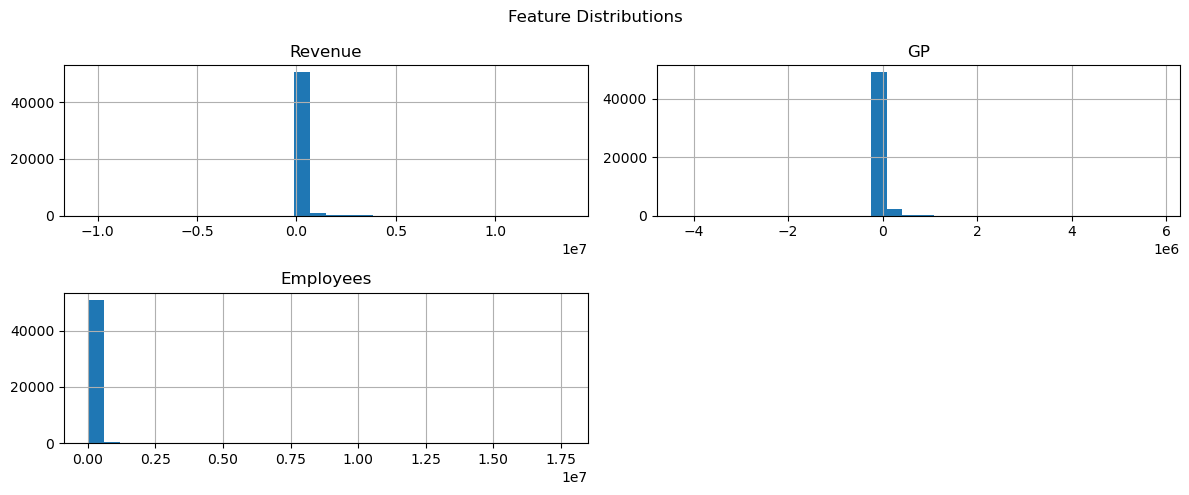

In [7]:
#  Visualizations (Histograms & Boxplots & Correlation Heatmap)
df[['Revenue', 'GP', 'Employees']].hist(bins=30, figsize=(12, 5))
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

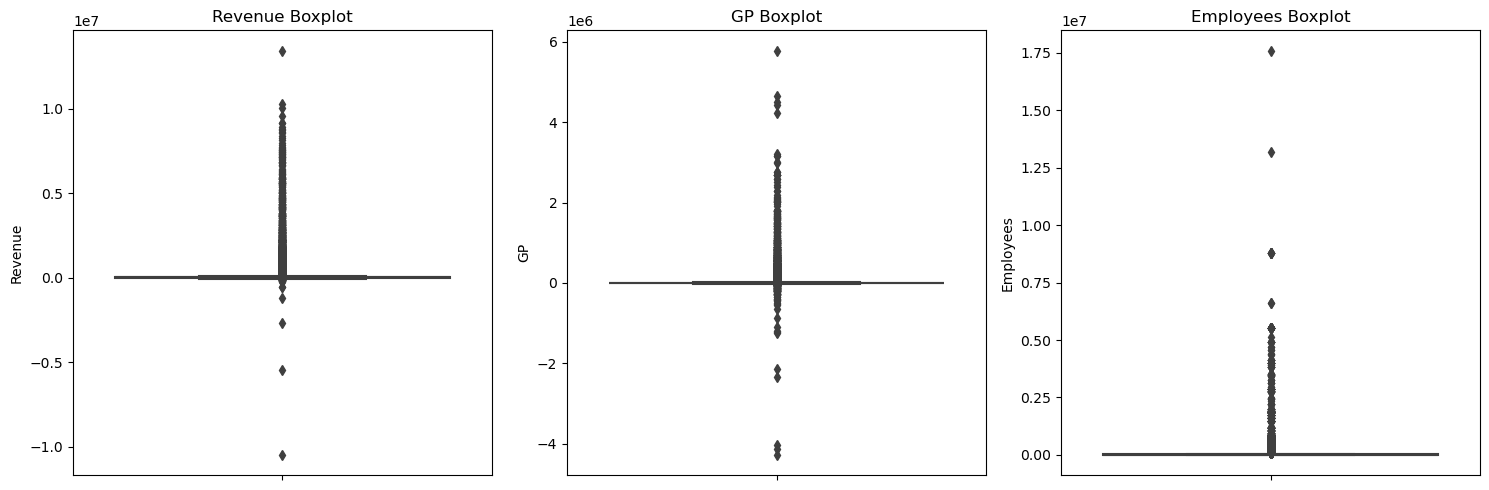

In [9]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Revenue', 'GP', 'Employees']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()

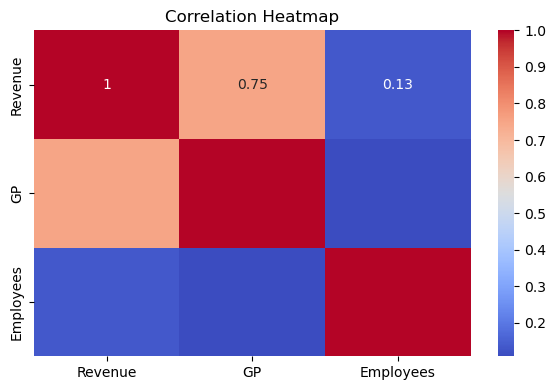

In [11]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Revenue', 'GP', 'Employees']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [13]:

features = ['Revenue', 'GP', 'Employees']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

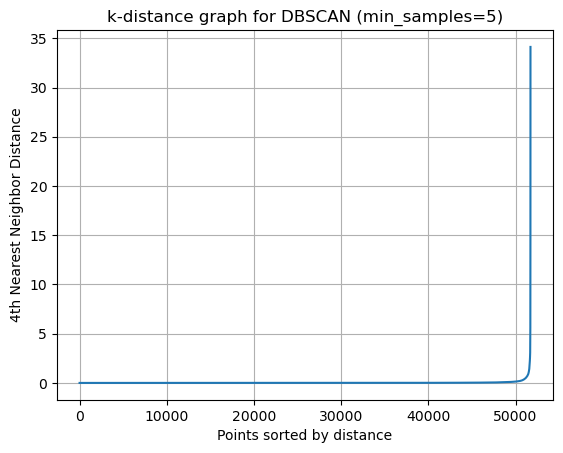

In [27]:
# k-distance plot to choose right eps for DBSCAN
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances and plot
import matplotlib.pyplot as plt
distances = np.sort(distances[:, 4])  # 4th neighbor = min_samples - 1
plt.plot(distances)
plt.title("k-distance graph for DBSCAN (min_samples=5)")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.grid()
plt.show()

In [ ]:
# The curve rises sharply around 1.8 – 2.5

In [29]:
#  DBSCAN Clustering
dbscan = DBSCAN(eps=2, min_samples=5)  
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

In [31]:
#  PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


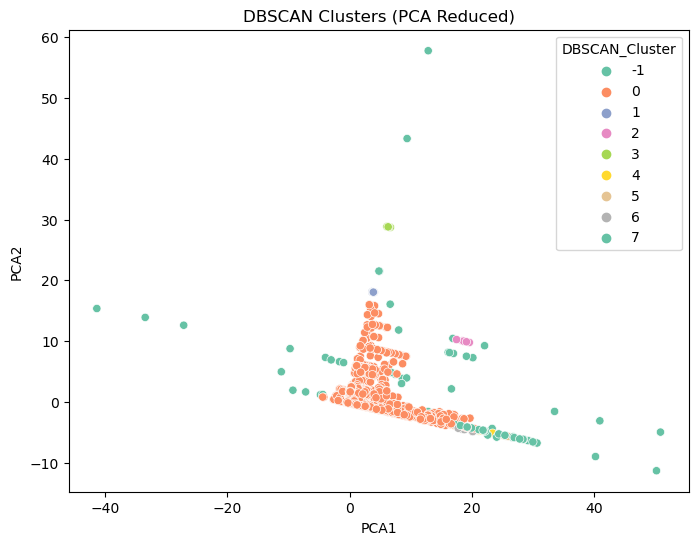

In [33]:
#  Plot PCA with DBSCAN Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set2')
plt.title('DBSCAN Clusters (PCA Reduced)')
plt.show()

In [51]:
#  Cluster Summary

cluster_summary = df.groupby('DBSCAN_Cluster')[features].mean().map(lambda x: f"{x/1e6:.2f}M" if abs(x) >= 1e6 else f"{x/1e3:.2f}k" if abs(x) >= 1e3 else f"{x:.2f}")
print("cluster_summary:\n", cluster_summary)

cluster_summary:
                 Revenue      GP Employees
DBSCAN_Cluster                           
-1                3.84M   1.09M     1.80M
 0               80.56k  19.71k    51.75k
 1               64.48k  15.31k     5.54M
 2                4.05M   1.53M     4.15M
 3              110.76k  24.76k     8.80M
 4                7.64M   1.47M    11.80k
 5                8.92M   1.76M    17.50k
 6                2.58M   2.57M     9.40k
 7                5.33M   1.63M    86.88k


In [61]:
# Number of clients in each DBSCAN cluster
df['DBSCAN_Cluster'].value_counts()


DBSCAN_Cluster
 0    51589
-1       65
 1       26
 3        7
 6        6
 4        6
 2        5
 5        4
 7        4
Name: count, dtype: int64

In [65]:
# Client Types

print(" * Low ROI Clients → Cluster 0, 1, 3")
print(" * High Employee Burden / Inefficient → Cluster 1, 3")
print(" * Strategic Lean Clients → Cluster 4, 6")
print(" * Balanced High Performers → Cluster 2, 5, 7")
print(" *Large teams , Low ROI clients → Cluster -1")

 * Low ROI Clients → Cluster 0, 1, 3
 * High Employee Burden / Inefficient → Cluster 1, 3
 * Strategic Lean Clients → Cluster 4, 6
 * Balanced High Performers → Cluster 2, 5, 7
 *Large teams , Low ROI clients → Cluster -1
